<a href="https://colab.research.google.com/github/hipster-x/Scel/blob/main/PR2_sssl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Практическая работа №2. Анализ логов

Выполнил студент ББМО-02-23 Евдокимов Артём Михайлович

Вариант 6 (Hadoop)

Desktop Screenshot 2024.10.04 - 17.20.46.85.png

In [1]:
import math
print (5%16+1)

6


## Клонирование репозитория с логами для их анализа

In [2]:
import os.path

if not os.path.isdir("./loghub/"):
    !git clone https://github.com/logpai/loghub

Cloning into 'loghub'...
remote: Enumerating objects: 575, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 575 (delta 145), reused 135 (delta 132), pack-reused 404 (from 1)
Receiving objects: 100% (575/575), 7.27 MiB | 13.09 MiB/s, done.
Resolving deltas: 100% (267/267), done.


## Задание регулярного выражения для парсинга логов

In [3]:
import re

pattern = r'(\d{4}-\d{2}-\d{2})\s(\d{2}:\d{2}:\d{2},\d{3})\s(\w+)\s(\[(.*)\])+\s(\S+):\s(.*)'

Регулярное выражение извлекает все поля записи лога и делит его на следующие группы:

Для примера возьмем строчку из логов:

---
```
2015-10-18 18:01:49,228 INFO [main] org.apache.hadoop.mapreduce.v2.app.MRAppMaster: Using mapred newApiCommitter.

```
---

Date `(\d{4}-\d{2}-\d{2})`

Time `(\d{2}:\d{2}:\d{2}\,\d{3})`

Level `(\w+)`

Process `(\[(.*)\])`

Component `(\S+):`

Content `(.*)`

## Создание базы данных

In [4]:
if not os.path.isdir("./db/"):
  os.makedirs("./db/")

In [5]:
import sqlite3

db_path = './db/logs.db'

connection = sqlite3.connect(db_path)
cursor = connection.cursor()

cursor.execute("DROP TABLE IF EXISTS logs")
cursor.execute("CREATE TABLE logs (id INTEGER PRIMARY KEY AUTOINCREMENT, date text, time text, level text, proc text, component text, content text)")

connection.commit()
cursor.close()
connection.close()

## Парсинг логов и сохранение в БД

In [7]:
connection = sqlite3.connect(db_path)
cursor = connection.cursor()

cursor.execute("DELETE FROM logs")

with open('./loghub/Hadoop/Hadoop_2k.log', 'r', encoding='utf-8') as log_file:
    for line in log_file:
        log_match = re.match(pattern, line)
        if log_match:
            date = log_match.group(1) # Date
            time = log_match.group(2) # Time
            level = log_match.group(3) # Level
            proc = log_match.group(4) # Process
            component = log_match.group(6) # Component
            content = log_match.group(7) # Content
            values = (date, time, level, proc, component, content)
            sql = "INSERT INTO logs (date, time, level, proc, component, content) VALUES (?, ?, ?, ?, ?, ?)"
            print(date, time, level, proc, component, content)
            cursor.execute(sql, values)

connection.commit()
cursor.close()
connection.close()

2015-10-18 18:01:47,978 INFO [main] org.apache.hadoop.mapreduce.v2.app.MRAppMaster Created MRAppMaster for application appattempt_1445144423722_0020_000001
2015-10-18 18:01:48,963 INFO [main] org.apache.hadoop.mapreduce.v2.app.MRAppMaster Executing with tokens:
2015-10-18 18:01:48,963 INFO [main] org.apache.hadoop.mapreduce.v2.app.MRAppMaster Kind: YARN_AM_RM_TOKEN, Service: , Ident: (appAttemptId { application_id { id: 20 cluster_timestamp: 1445144423722 } attemptId: 1 } keyId: -127633188)
2015-10-18 18:01:49,228 INFO [main] org.apache.hadoop.mapreduce.v2.app.MRAppMaster Using mapred newApiCommitter.
2015-10-18 18:01:50,353 INFO [main] org.apache.hadoop.mapreduce.v2.app.MRAppMaster OutputCommitter set in config null
2015-10-18 18:01:50,509 INFO [main] org.apache.hadoop.mapreduce.v2.app.MRAppMaster OutputCommitter is org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter
2015-10-18 18:01:50,556 INFO [main] org.apache.hadoop.yarn.event.AsyncDispatcher Registering class org.apache.ha

## Чтение из БД

In [10]:
import pandas as pd

with sqlite3.connect(db_path) as connection:
    log_df = pd.read_sql_query("SELECT * FROM logs", connection)

log_df.columns = ["id", "date", "time", "level", "proc", "component", "content"]

log_df

,id,date,time,level,proc,component,content
0,2001,2015-10-18,"18:01:47,978",INFO,[main],org.apache.hadoop.mapreduce.v2.app.MRAppMaster,Created MRAppMaster for application appattempt...
1,2002,2015-10-18,"18:01:48,963",INFO,[main],org.apache.hadoop.mapreduce.v2.app.MRAppMaster,Executing with tokens:
2,2003,2015-10-18,"18:01:48,963",INFO,[main],org.apache.hadoop.mapreduce.v2.app.MRAppMaster,"Kind: YARN_AM_RM_TOKEN, Service: , Ident: (app..."
3,2004,2015-10-18,"18:01:49,228",INFO,[main],org.apache.hadoop.mapreduce.v2.app.MRAppMaster,Using mapred newApiCommitter.
4,2005,2015-10-18,"18:01:50,353",INFO,[main],org.apache.hadoop.mapreduce.v2.app.MRAppMaster,OutputCommitter set in config null
...,...,...,...,...,...,...,...
1995,3996,2015-10-18,"18:10:54,202",WARN,[LeaseRenewer:msrabi@msra-sa-41:9000],org.apache.hadoop.ipc.Client,Address change detected. Old: msra-sa-41/10.19...
1996,3997,2015-10-18,"18:10:54,202",WARN,[LeaseRenewer:msrabi@msra-sa-41:9000],org.apache.hadoop.hdfs.LeaseRenewer,Failed to renew lease for [DFSClient_NONMAPRED...
1997,3998,2015-10-18,"18:10:54,546",INFO,[RMCommunicator Allocator],org.apache.hadoop.ipc.Client,Retrying connect to server: msra-sa-41:8030. A...
1998,3999,2015-10-18,"18:10:54,546",ERROR,[RMCommunicator Allocator],org.apache.hadoop.mapreduce.v2.app.rm.RMContai...,ERROR IN CONTACTING RM.


## Построение графика распределения записей по 15 наиболее часто встречаемым компонентам, создавшим запись в логах

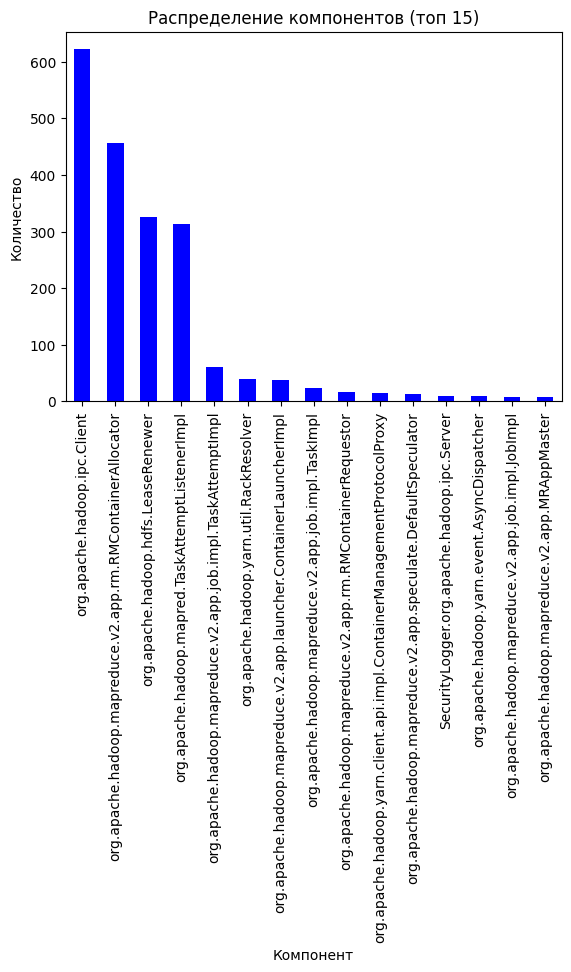

In [17]:
components_distrib = log_df['component'].value_counts()[:15].plot(kind='bar', color ='blue')

components_distrib.plot(kind='bar')

plt.xlabel('Компонент')
plt.ylabel('Количество')
plt.title('Распределение компонентов (топ 15)')
plt.show()

## Построение графика распределения записей уровня логирования


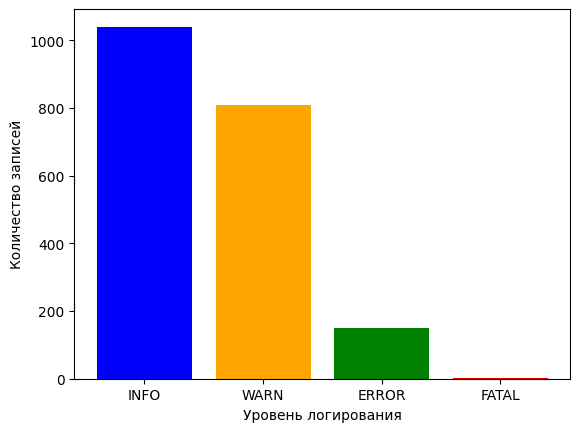

In [15]:
import matplotlib.pyplot as plt

log_level_distrib = log_df['level'].value_counts()

x = log_level_distrib.index
y = log_level_distrib.values

verbose_xticks = ["INFO", "WARN", "ERROR", "FATAL"]

colors = ['blue', 'orange', 'green', 'red']

plt.bar(x, y, color=colors)
plt.xticks(ticks=range(len(verbose_xticks)), labels=verbose_xticks)
plt.xlabel('Уровень логирования')
plt.ylabel('Количество записей')
plt.show()

## Частота появления

<ipython-input-19-fb6ea380fda9>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  log_df['Id'] = pd.to_datetime(log_df['time'])


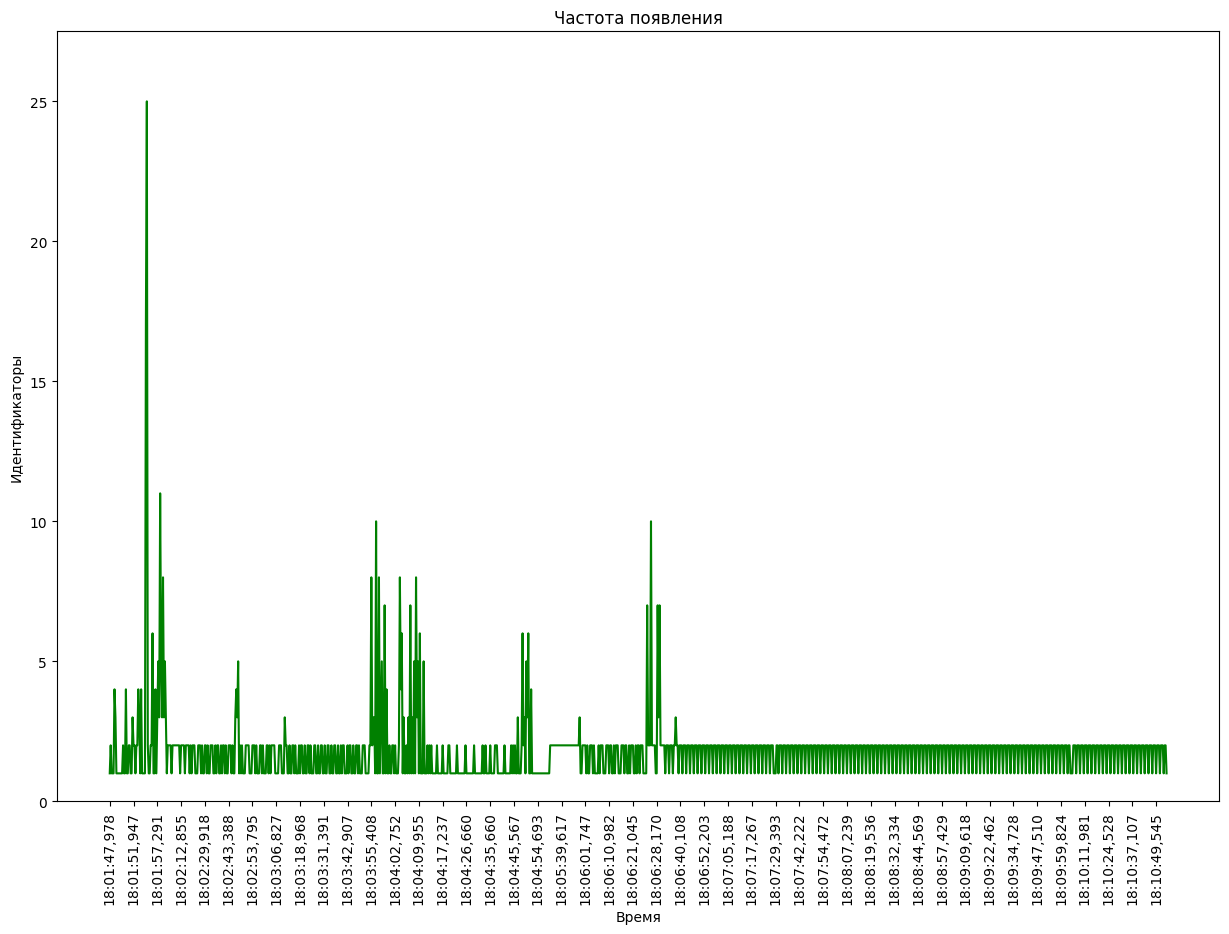

In [19]:
log_df['Id'] = pd.to_datetime(log_df['time'])
cbs_count = log_df.groupby('time').size()

plt.figure(figsize=(15, 10))
plt.plot(cbs_count.index, cbs_count.values, linestyle='-', color='green')
plt.xlabel('Время')
plt.ylabel('Идентификаторы')
plt.ylim(bottom=0, top=max(cbs_count.values) * 1.1)

step = 25
plt.xticks(cbs_count.index[::step], rotation=90)

plt.title('Частота появления')
plt.show()

## Количество событий

<ipython-input-31-1f9b289d8906>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  err_df['time'] = pd.to_datetime(err_df['time'])
<ipython-input-31-1f9b289d8906>:7: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  err_count = err_count.resample('5S').sum()


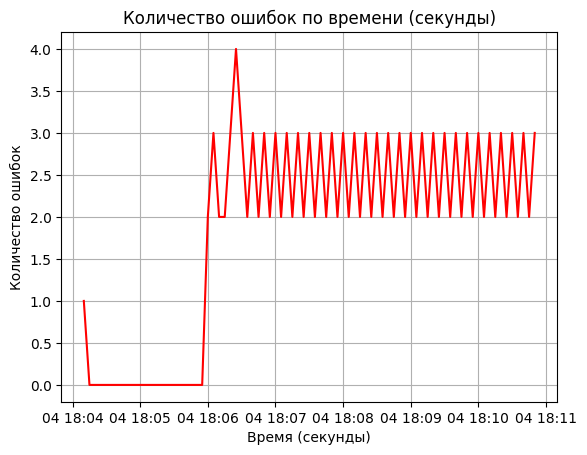

In [31]:
err_df = log_df[log_df['level'] == 'ERROR'].copy()

err_df['time'] = pd.to_datetime(err_df['time'])

err_count = err_df.groupby('time').size()

err_count = err_count.resample('5S').sum()
err_count = err_count.fillna(0)

plt.plot(err_count.index, err_count.values, linestyle='-', color='r')
plt.xlabel('Время (секунды)')
plt.ylabel('Количество ошибок')
plt.title('Количество ошибок по времени (секунды)')
plt.grid(True)
plt.show()
